# Experiments with MxNet and Handwritten Digits recognition

In this Jupyter notebook, I'd like to experiment with 'Hello world' multiclass logistic regression problem - recognition of handwritten digits. I will use [MxNet](https://mxnet.apache.org/) and its [Gluon API](https://mxnet.apache.org/gluon/index.html) to build nueral network. The dataset is [MNIST](http://yann.lecun.com/exdb/mnist/) that contains lots handwritten digits. I am going to use different optimizers that provided by MxNet to find out how they influence model training speed and prediction accuracy.

### Package import

* `mxnet.nd` is a subpackage contains all needed functionality to work wiht N-dimensions arrays
* `mxnet.autograd` provides functionality to compute [gradient](https://en.wikipedia.org/wiki/Gradient) for learning our models
* `mxnet.gluon` is an imperative API to build models

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
import matplotlib.pyplot as plt

### Configure MxNet context. 

I run models on CPU here; however, MxNet also supports GPU.

In [2]:
model_ctx = mx.cpu()

### Parameters for experiments

* `picture_size_pixels` - the size of one picture side (in this case 28, MNIST digits are pictures with 28x28 pixels)
* `num_inputs` - how many inputs our models will have (in this case 784, each pixel on picture will have corresponding input signal)
* `num_outputs` - how many outputs our models will have (in this case we want to know what digit on a picture, each output signal is reponsible for each digit from 0 till 9, thus 10)

In [3]:
picture_size_pixels = 28
num_inputs = picture_size_pixels * picture_size_pixels
num_outputs = 10

### Prepearing dataset

#### Transform function

First of all, I define a `transform` function that will be invoked on each picture of digits from the dataset to make it "digestible" for a network. It takes two parameters:

* `data` which is a digit picture that represented as `mxnet.nd.array`
* `label` which is the value of what digit depicted in the picture.

The function converts `data` into an array that will contain float numbers between `0.0` and `1.0`

In [4]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

#### Loading dataset

To get the MNIST dataset with MxNet is very easy. All you need is to instantiate `mxnet.gluon.data.vision.MNIST` objects, that's it. It will download and store dataset on your machine. It takes three parameters:

* `root` which is the path on your machine where dataset should be stored, by default it's `~/.mxnet/datasets/mnist`, * `train` which is flag that indicate which dataset to load `Training` or `Testing`
* `transform` is the function that will be invoke on dataset item before retrieving it from dataset.

Also, I will user `mxnet.gluon.data.DataLoader` class to load dataset in my python script. It takes a few parameters (that you can find in [documentation](https://mxnet.apache.org/api/python/gluon/data.html#mxnet.gluon.data.DataLoader)), but I provide only three of them: 

* `dataset` as `mxnet.gluon.data.vision.MNIST` object
* `batch_size` is integer parameter to specify how many items `DataLoader` should provide at once
* `shuffle` should dataset be shuffled or not.

In [5]:
batch_size = 64

train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, transform=transform), batch_size, shuffle=False)

### Initialize network

I define general function to instantiate a network using Gluon API here.

In [6]:
def create_network():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(num_outputs))
        net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)
    return net

Let's break the MxNet API. First of all, `mxnet.gluon.nn.Sequential` - is simple object that helps build model by pushing one layer on another. We need use `name_scope` method that will automatically give name of parameters for added layers; these parameters will be initialized and used to create optimizer later. `mxnet.gluon.nn.Dense` - is a object that represent one network layer where each node has connection with each node of layer below. It our case the only one layer that has `10` outputs; the number of inputs MxNet will automatically figure out when we start feeding the network.

### To Be Trained - Model Needs Feedback

To calculate how 'wrong' a prediction of our model is we need to use loss function. I use the [softmax](https://en.wikipedia.org/wiki/Softmax_function) [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) function here.

In [7]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Measuring model accuracy

You can comapre only when you can measure. The below `evaluate_accuracy` function, as its name stands, evaluates network accuracy for dataset. It iterates over `data_iterator` and feeds `data` into `net`. We need to be sure that `data` and `label` in the same context otherwise MxNet will throw an error. It accomplished by calling `as_in_context` function with `model_ctx` context. Also, it needs to `reshape` `data` because it is a 3D array with sizes 28x28x1. Giving `-1` as first item of tuple to `reshape` function we are telling MxNet to figure out the number of rows in a new  array. Because `num_inputs = 784` (which is equal to `28*28*1`) thus we get an 1D array with length `784`. Then we get what digit our model guessed with `nd.argmax`; and update `accuracy` object.

In [8]:
def evaluate_accuracy(data_iterator, net):
    accuracy = mx.metric.Accuracy()
    for data, label in data_iterator:
        data = data.as_in_context(model_ctx).reshape((-1, num_inputs))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        accuracy.update(preds=predictions, labels=label)
    return accuracy.get()[1]

### Prepering list of optimizers

I instanciate list of `optimizers` as `tuple`s, where the first item is the name that MxNet can recognize, the second is parameters for the optimizer (I took them from [Gluon tutorial part about network optimization](http://gluon.mxnet.io/chapter06_optimization/optimization-intro.html)), the third one is the color with which prediction accuracy will be depicted on plots and the last one is the labels for plots. Nice [article about optimizers](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop). I found it very intresting with right level of ditails.

In [9]:
optimizers = [
    ('sgd', {'learning_rate': 0.1}, 'red', 'sgd'),
    ('sgd', {'learning_rate': 0.2, 'momentum': 0.9 }, 'blue', 'sgd-momentum'),
    ('adagrad', {'learning_rate': 0.9}, 'green', 'adagrad'),
    ('rmsprop', {'learning_rate': 0.03, 'gamma1': 0.9}, 'orange', 'rmsprop'),
    ('adadelta', {'rho': 0.9999}, 'black', 'adadelta')
]

### Experiments

Following code snippet contains code to run the networks with different optimizers. Each network will run training over `5` epochs. I am recording accuracy at each of the epoch, and then pass it to build a plot and then printing to notebook output.

I will highlight the most interesting lines of the code here:

```python
trainer = gluon.Trainer(net.collect_params(), name, params)
```

This line is instanciating optimizer for the network with its parameters, optimizer's name and optimizer's parameters that we set earlier.

```python
with autograd.record():
    output = net(data)
    loss = softmax_cross_entropy(output, label)
loss.backward()
trainer.step(batch_size)
```

Here is where all model's training occures. We do a [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) procedure; compute a direction in which our model moves in the trainings and corelate it that the model can make a better predictions next time.

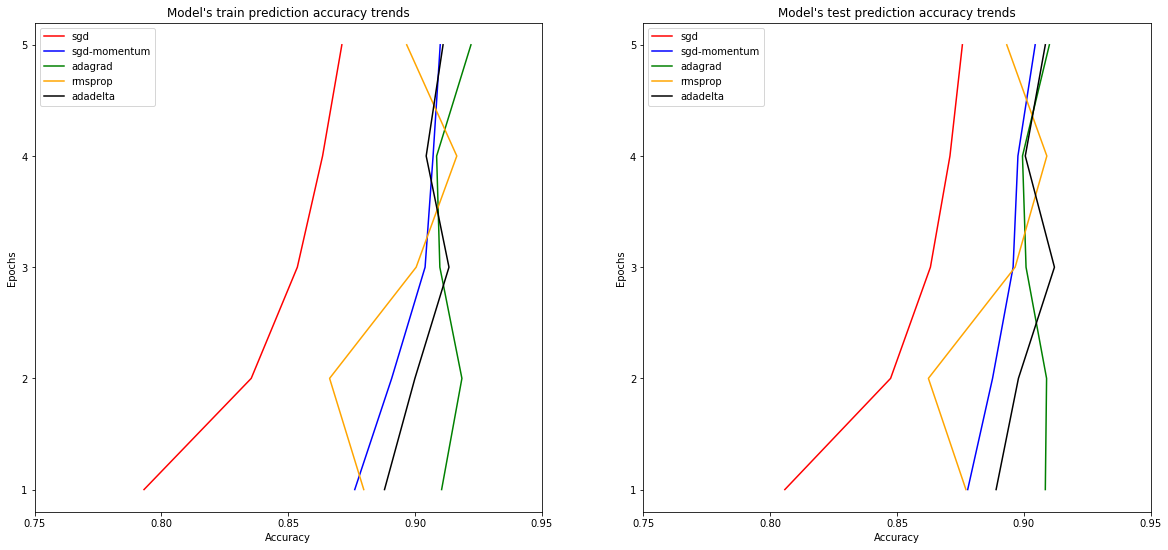

In [11]:
epochs = 5

fig = plt.figure(figsize=(20, 9))
train_plot = fig.add_subplot(1, 2, 1)
test_plot = fig.add_subplot(1, 2, 2)

final_accuracy = {}

for optimizer in optimizers:
    name, params, color, key = optimizer
    
    net = create_network()
    trainer = gluon.Trainer(net.collect_params(), name, params)
    test_accuracy = []
    train_accuracy = []

    for e in range(epochs):
        for data, label in train_data:
            data = data.as_in_context(model_ctx).reshape((-1, num_inputs))
            label = label.as_in_context(model_ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)

        test_accuracy.append(evaluate_accuracy(test_data, net))
        train_accuracy.append(evaluate_accuracy(train_data, net))
    
    
    y_ticks = [e + 1 for e in range(epochs)]
    x_ticks = np.arange(0.75, 1.0, 0.05)
    def create_plot(line_plot, data, kind):
        line_plot.plot(data, y_ticks, c=color, label=key)
        line_plot.legend(loc='upper left')
        line_plot.set_title("Model's {} prediction accuracy trends".format(kind))
        line_plot.set_xlabel('Accuracy')
        line_plot.set_xticks(x_ticks)
        line_plot.set_ylabel('Epochs')
        line_plot.set_yticks(y_ticks)
        
    create_plot(train_plot, train_accuracy, 'train')
    create_plot(test_plot, test_accuracy, 'test')

    final_accuracy[key] = (train_accuracy, test_accuracy)

plt.show()

In [106]:
for name, acc in final_accuracy.items():
    print('Optimizer: "{}"'.format(name))
    train, test = acc
    for i in range(epochs):
        print('Train accuracy: {:.2%}, Test accuracy: {:.2%}'.format(train[i], test[i]))

Optimizer: "sgd"
Train accuracy: 80.18%, Test accuracy: 81.41%
Train accuracy: 83.99%, Test accuracy: 84.86%
Train accuracy: 85.59%, Test accuracy: 86.08%
Train accuracy: 86.69%, Test accuracy: 87.23%
Train accuracy: 87.42%, Test accuracy: 87.67%
Optimizer: "sgd-momentum"
Train accuracy: 88.50%, Test accuracy: 88.85%
Train accuracy: 90.59%, Test accuracy: 90.26%
Train accuracy: 90.81%, Test accuracy: 90.53%
Train accuracy: 90.95%, Test accuracy: 90.28%
Train accuracy: 91.53%, Test accuracy: 90.67%
Optimizer: "adagrad"
Train accuracy: 90.48%, Test accuracy: 90.08%
Train accuracy: 91.50%, Test accuracy: 90.59%
Train accuracy: 92.29%, Test accuracy: 91.30%
Train accuracy: 91.83%, Test accuracy: 90.58%
Train accuracy: 92.39%, Test accuracy: 91.49%
Optimizer: "rmsprop"
Train accuracy: 88.99%, Test accuracy: 88.26%
Train accuracy: 90.35%, Test accuracy: 90.28%
Train accuracy: 90.29%, Test accuracy: 89.79%
Train accuracy: 89.37%, Test accuracy: 88.71%
Train accuracy: 91.70%, Test accuracy: 91

## Sum up

For the task of recognizing handwritten digits all optimizers provide feedback for reasonable prediction. As you can see from plots the model with 'sgd' optimizer has sloping prediction rate.